In [52]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import log

### In this version if a healthy individual(blue) is connected to an infected(red) there is a probability I that they
### will become infected. If an individual is red there is a probability R of becoming blue. We assume no immunity 
### after recovery, and also DONT assume that if an infected individual has only infected neighours they are 
### immune to recovery

In [53]:
N = 1000
k = 5 # on average the number of friends one has
p = 0.4 # probability of rewiring in the Wats-Strogatz algorithm

R = 0.01 #recovery probability
I = 0.1 #infection probability


init_inf = 0.02 # proportion of infected people
threshold_up = int(0.2*N) # when the disease is successful
threshold_down = int(0.01*N) # when it dies off

In [54]:
def color_edges(G):
    
    for j in range(N):
        G.nodes[j]['color'] = 'blue' # not infected
    for j in init_distr:
        G.nodes[j]['color'] = 'red' # infect
    return G

In [55]:
def evolve(G, infic, inf_time):
    nextstate = np.zeros(N) # 0 is blue, 1 is red
    while (threshold_down<infic) and (infic<threshold_up):
        for n, nbrs in G.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
            if G.nodes[n]['color'] == 'blue':
                if any([G.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                    nextstate[n]=np.random.binomial(1,I)
                else:
                    nextstate[n]=0
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate[n]=np.random.binomial(1,(1-R))
        infic = sum(nextstate)
        inf_time = np.append(inf_time,[100*infic/N])

        for j in range(N):
            if nextstate[j] == 0:
                G.nodes[j]['color'] = 'blue'
            else:
                G.nodes[j]['color'] = 'red'
            
    return G, infic, inf_time

In [56]:
def evolve_with_immunity(G, infic, inf_time):
    nextstate = np.zeros(N) # 0 is blue, 1 is red
    while (threshold_down<infic<threshold_up):
        for n, nbrs in G.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
                if G.nodes[n]['color'] == 'blue':
                    if any([G.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                        nextstate[n]=np.random.binomial(1,I)
                    else:
                        nextstate[n]=0
                else:                            #else it is infected and has probability of flipping and becoming succeptible again
                    nextstate[n]=int(np.random.binomial(1,R) + 1) #2 means immune now
        infic = list(nextstate).count(1)
        inf_time = np.append([inf_time],[100*infic/N])
        for j in range(N):
            if nextstate[j] == 0:
                G.nodes[j]['color'] = 'blue'
            elif nextstate[j] == 1:
                G.nodes[j]['color'] = 'red'
            else:
                G.nodes[j]['color'] = 'green' #immune

    
    return G, infic, inf_time

In [57]:
def evolve_variable_rate(G, infic, inf_time):
    nextstate = np.zeros(N) # 0 is blue, 1 is red
    
    R0 = infic
    
    while (threshold_down<infic) and (infic<threshold_up):
        for n, nbrs in G.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
            if G.nodes[n]['color'] == 'blue':
                if any([G.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                    nextstate[n]=np.random.binomial(1,I)
                else:
                    nextstate[n]=0
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate[n]=np.random.binomial(1,(1-R*(1 + (infic-R0)/R0)))
        R0 = infic
        infic = sum(nextstate)
        inf_time = np.append(inf_time,[100*infic/N])

        for j in range(N):
            if nextstate[j] == 0:
                G.nodes[j]['color'] = 'blue'
            else:
                G.nodes[j]['color'] = 'red'
            
    return G, infic, inf_time

In [58]:
G = nx.connected_watts_strogatz_graph(N,k,p) # Small-world network
G2 = nx.scale_free_graph(N)                  # Scale free

In [59]:
init_distr = np.random.choice(N, int(round(N*init_inf)), replace=False) #Initial infected nodes

inf = int(round(N*init_inf))

In [60]:
G = color_edges(G)
G2 = color_edges(G2)

In [61]:
nextstate = np.zeros(N) # 0 is blue, 1 is red
inf_t =np.array([100*inf/N]) # infected at time t

inf2=int(round(N*init_inf))
inf_t2 =np.array([100*inf2/N]) 

In [62]:
G, inf, inf_t = evolve(G,inf,inf_t)                      
G2, inf2, inf_t2 = evolve(G2,inf2,inf_t2)

For small-world, the disease won and the infection level is 20.6%


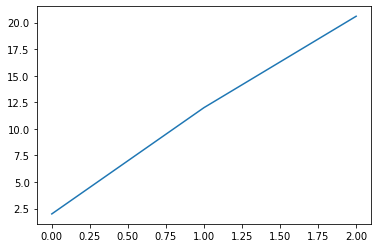

In [63]:
if inf<threshold_down:
    print("For small-world, the disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("For small-world, the disease won and the infection level is {}%".format(round(100*inf/N,2)) )

plt.plot(inf_t)
plt.show()

For Scale free, the disease won and the infection level is 21.4%


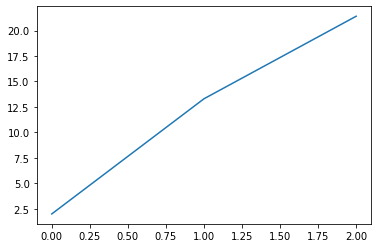

In [64]:
if inf<threshold_down:
    print("For Scale free, the disease was wiped out and the infection level is {}".format(round(100*inf2/N,2)) )
if inf>threshold_up:
    print("For Scale free, the disease won and the infection level is {}%".format(round(100*inf2/N,2)) )

plt.plot(inf_t2)
plt.show()

This is expected since the recovery rate is much lower than the infection rate, there is essentially no way for the dissease to slow down.

We shall continue looking at the ones where we introduce immunity.

In [65]:
F = nx.connected_watts_strogatz_graph(N,k,p) 

color_edges(F)
    
inf = int(round(N*init_inf))
inf_t_immune = np.array([100*inf/N])

In [66]:
F2 = nx.scale_free_graph(N)

color_edges(F2)
    
inf2 = int(round(N*init_inf))
inf_t_immune2 = np.array([100*inf2/N])

In [67]:
F, inf, inf_t_immune = evolve_with_immunity(F, inf, inf_t_immune)

In [68]:
F2, inf2, inf_t_immune2 = evolve_with_immunity(F2, inf2, inf_t_immune2)
    

The disease won and the infection level is 26.8%


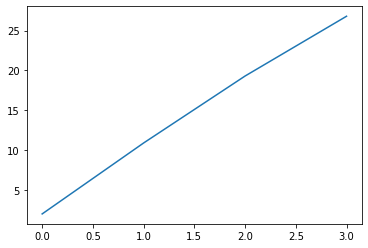

In [69]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t_immune)
plt.show()

For Scale free, the disease won and the infection level is 27.4%


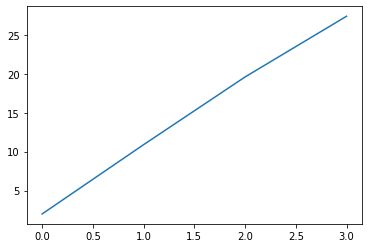

In [70]:
if inf2<threshold_down:
    print("For Scale free, the disease was wiped out and the infection level is {}".format(round(100*inf2/N,2)) )
if inf2>threshold_up:
    print("For Scale free, the disease won and the infection level is {}%".format(round(100*inf2/N,2)) )

plt.plot(inf_t_immune2)
plt.show()

Now consider a model where the infection rate of an individual depends on the proportion od neighbours infected. Treat both, being red and being blue as infection states. This means, if an individual is red, then we look at the proportion of neighbours that are blue to calculate the switch rate. Similarly for blue individuals. Note, even if a node is blue and all its neighbours are red (or vice-versa) there is still a possibility of the individual to remain blue (This should reflect the fact that changing opinions is difficult). We do however want that if a blue individual is connected to only blue neighbours, the probability of becomming radicalized is 0. We shall assume first that the infection rate of red (radical ideas) is higher than blue, so that it makes sense to talk about an idea to be successful, otherwise it is obvious that blue would win if the starting percentage of red is around 3% as reffered in the paper.

We consider no Immunity.

In [71]:
H = nx.connected_watts_strogatz_graph(N,k,p) 

color_edges(H)
    
inf = int(round(N*init_inf))
inf_t = np.array([100*inf/N])

I = 0.5 #at maximum red neighbours this is the flipping rate for blue
R = 0.3 #at maximum blue neighbours this is the flipping rate for red

In [72]:
H2 = nx.scale_free_graph(N)

for j in range(N):
    H2.nodes[j]['color'] = 'blue' 
    
for j in init_distr:
    H2.nodes[j]['color'] = 'red'
    
inf2 = int(round(N*init_inf))
inf_t2 = np.array([100*inf2/N])
nextstate = np.zeros(N)
nextstate2 = np.zeros(N)

In [73]:
while (threshold_down<inf<threshold_up):
    for n, nbrs in H.adj.items():           #These two lines are a weird artefact for accesing neighbours in nx
        countr = 0                      #count red neighbours
        for nbr, eatr in nbrs.items():
            if H.nodes[nbr]['color']=='red':
                countr = countr + 1
        if H.nodes[n]['color'] == 'blue':
            nextstate[n]=np.random.binomial(1,I*countr/len(nbrs))
        else:                            #else it is infected and has probability of flipping and becoming succeptible again
            nextstate[n]=np.random.binomial(1,(1-R*(1-(countr/len(nbrs))))) 
    inf = list(nextstate).count(1)
    inf_t = np.append([inf_t],[100*inf/N])
    for j in range(N):
        if nextstate[j] == 0:
            H.nodes[j]['color'] = 'blue'
        elif nextstate[j] == 1:
            H.nodes[j]['color'] = 'red'
    

In [74]:
while (threshold_down<inf2<threshold_up):
    for n, nbrs in H2.adj.items():           #These two lines are a weird artefact for accesing neighbours in nx
        if len(nbrs)>0:
            countr = 0                      #count red neighbours
            for nbr, eatr in nbrs.items():
                if H2.nodes[nbr]['color']=='red':
                    countr = countr + 1
            if H2.nodes[n]['color'] == 'blue':
                nextstate2[n]=np.random.binomial(1,I*countr/len(nbrs))
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate2[n]=np.random.binomial(1,(1-R*(1-(countr/len(nbrs))))) 
        else:
            if H2.nodes[n]['color']=='blue':
                nextstate2[n]=0
            else:
                nextstate2[n]=1
    inf2 = list(nextstate2).count(1)
    inf_t2 = np.append([inf_t2],[100*inf2/N])
    for j in range(N):
        if nextstate2[j] == 0:
            H2.nodes[j]['color'] = 'blue'
        elif nextstate2[j] == 1:
            H2.nodes[j]['color'] = 'red'
    

The disease won and the infection level is 23.1%


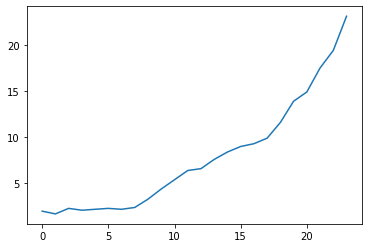

In [75]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t)
plt.show()

For Scale free, the disease was wiped out and the infection level is 0.9


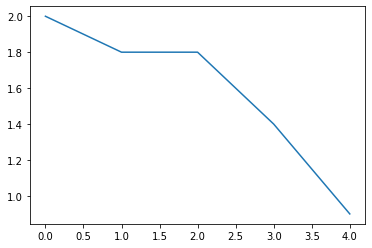

In [76]:
if inf2<threshold_down:
    print("For Scale free, the disease was wiped out and the infection level is {}".format(round(100*inf2/N,2)) )
if inf2>threshold_up:
    print("For Scale free, the disease won and the infection level is {}%".format(round(100*inf2/N,2)) )

plt.plot(inf_t2)
plt.show()

In [84]:
p = 2*log(N)/N
Gnp = nx.gnp_random_graph(N,p)

In [85]:
color_edges(Gnp)

inf = int(round(N*init_inf))
inf_t = np.array([100*inf/N])

Gnp, inf, inf_t = evolve_with_immunity(Gnp, inf, inf_t)

The disease won and the infection level is 52.1%


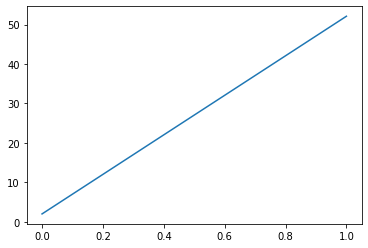

In [86]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t)
plt.show()

In [87]:
color_edges(Gnp)

inf = int(round(N*init_inf))
inf_t = np.array([100*inf/N])

Gnp, inf, inf_t = evolve_variable_rate(Gnp, inf, inf_t)

The disease won and the infection level is 50.2%


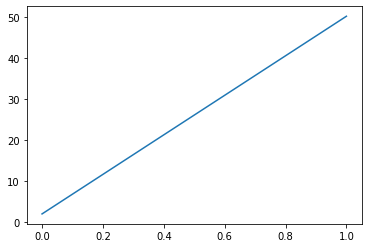

In [88]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t)
plt.show()